<a href="https://colab.research.google.com/github/ohallao/MoneyBall-Brasileirao/blob/main/Performance_times_brasileirao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install adjustText
!pip install fuzzywuzzy
!pip install soccerdata

In [2]:
import soccerdata as sd
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import random
import unidecode
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.cm as cm
from fuzzywuzzy import process
from adjustText import adjust_text

[01/11/25 18:43:36] INFO     No custom team name replacements found. You can configure these in       ]8;id=262172;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_config.py\_config.py]8;;\:]8;id=299046;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_config.py#90\90]8;;\
                             /root/soccerdata/config/teamname_replacements.json.                                   

                    INFO     Custom league dict loaded from                                          ]8;id=18755;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_config.py\_config.py]8;;\:]8;id=818872;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_config.py#194\194]8;;\
                             /root/soccerdata/config/league_dict.json.                                             

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# 2. Obtenção dos Dados

In [3]:
sd.FBref.available_leagues()
fbref = sd.FBref(leagues="BRA-Serie A", seasons=2024)
print(fbref.__doc__)

[01/11/25 18:43:37] INFO     Saving cached data to /root/soccerdata/data/FBref                       ]8;id=677069;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_common.py\_common.py]8;;\:]8;id=394092;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_common.py#263\263]8;;\

Provides pd.DataFrames from data at http://fbref.com.

    Data will be downloaded as necessary and cached locally in
    ``~/soccerdata/data/FBref``.

    Parameters
    ----------
    leagues : string or iterable, optional
        IDs of leagues to include. For efficiently reading data from the Top-5
        European leagues, use "Big 5 European Leagues Combined".
    seasons : string, int or list, optional
        Seasons to include. Supports multiple formats.
        Examples: '16-17'; 2016; '2016-17'; [14, 15, 16]
    proxy : 'tor' or dict or list(dict) or callable, optional
        Use a proxy to hide your IP address. Valid options are:
            - "tor": Uses the Tor network. Tor should be running in
              the background on port 9050.
            - dict: A dictionary with the proxy to use. The dict should be
              a mapping of supported protocols to proxy addresses. For example::

                  {
                      'http': 'http://10.10.1.10:3128',
     

In [4]:
team_season_std = fbref.read_team_season_stats(stat_type="standard")
team_season_std.head()

/usr/local/lib/python3.10/dist-packages/soccerdata/fbref.py:159: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pd.concat(dfs)
/usr/local/lib/python3.10/dist-packages/soccerdata/_common.py:145: UserWarning: Season id "2021" is ambiguous: interpreting as "20-21"
  warnings.warn(msg, stacklevel=1)


players_used   Age  Poss Playing Time  \
                                                                       MP   
league      season team                                                     
BRA-Serie A 2425   Ath Paranaense             31  26.2  46.9           38   
                   Atl Goianiense             40  26.5  47.4           38   
                   Atlético Mineiro           36  28.1  57.2           38   
                   Bahia                      30  27.7  55.8           38   
                   Botafogo (RJ)              38  27.9  53.8           38   

                                                     Performance          ...  \
                                    Starts   Min 90s         Gls Ast G+A  ...   
league      season team                                                   ...   
BRA-Serie A 2425   Ath Paranaense      418  3420  38          39  35  74  ...   
                   Atl Goianiense      418  3420  38          28  16  44  ...   
                   Atlético Mineiro    418  3420  38          47  23  70  ...   
                   Bahia               418  3420  38          49  40  89  ...   
                   Botafogo (RJ)       418  3420  38          58  41  99  ...   

                                    Per 90 Minutes                           \
                                               Ast   G+A  G-PK G+A-PK    xG   
league      season team                                                       
BRA-Serie A 2425   Ath Paranaense             0.92  1.95   1.0   1.92  1.24   
                   Atl Goianiense             0.42  1.16  0.66   1.08  1.07   
                   Atlético Mineiro           0.61  1.84  0.95   1.55  1.21   
                   Bahia                      1.05  2.34  1.24   2.29  1.35   
                   Botafogo (RJ)              1.08  2.61  1.42    2.5  1.51   

                                                                 \
                                      xAG xG+xAG  npxG npxG+xAG   
league      season team                                           
BRA-Serie A 2425   Ath Paranaense    0.99   2.23   1.2     2.19   
                   Atl Goianiense    0.72   1.79  0.96     1.68   
                   Atlético Mineiro  0.68    1.9  0.94     1.63   
                   Bahia             1.07   2.42  1.31     2.38   
                   Botafogo (RJ)     1.08   2.59  1.39     2.47   

                                                                                url  
                                                                                     
league      season team                                                              
BRA-Serie A 2425   Ath Paranaense    /en/squads/2091c619/Athletico-Paranaense-Stats  
                   Atl Goianiense     /en/squads/32d508ca/Atletico-Goianiense-Stats  
                   Atlético Mineiro      /en/squads/422bb734/Atletico-Mineiro-Stats  
                   Bahia                            /en/squads/157b7fee/Bahia-Stats  
                   Botafogo (RJ)              /en/squads/d9fdd9d9/Botafogo-RJ-Stats  

[5 rows x 32 columns]

In [5]:
sofascore = sd.Sofascore(leagues='BRA-Serie A', seasons='24')
print(sofascore.__doc__)

[01/11/25 18:44:04] INFO     Saving cached data to /root/soccerdata/data/Sofascore                   ]8;id=609462;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_common.py\_common.py]8;;\:]8;id=105806;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_common.py#263\263]8;;\

Provides pd.DataFrames from data available at http://www.sofascore.com.

    Data will be downloaded as necessary and cached locally in
    ``~/soccerdata/data/Sofascore``.

    Parameters
    ----------
    leagues : string or iterable, optional
        IDs of Leagues to include.
    seasons : string, int or list, optional
        Seasons to include. Supports multiple formats.
        Examples: '16-17'; 2016; '2016-17'; [14, 15, 16]
    proxy : 'tor' or dict or list(dict) or callable, optional
        Use a proxy to hide your IP address. Valid options are:
            - 'tor': Uses the Tor network. Tor should be running in
              the background on port 9050.
            - dict: A dictionary with the proxy to use. The dict should be
              a mapping of supported protocols to proxy addresses. For example::

                  {
                      'http': 'http://10.10.1.10:3128',
                      'https': 'http://10.10.1.10:1080',
                  }

            - 

In [6]:
league_table = sofascore.read_league_table()
league_table.head()

/usr/local/lib/python3.10/dist-packages/soccerdata/_common.py:145: UserWarning: Season id "2021" is ambiguous: interpreting as "20-21"
  warnings.warn(msg, stacklevel=1)


team  MP   W   D  L  GF  GA  GD  Pts
league      season                                               
BRA-Serie A 2425         Botafogo  38  23  10  5  59  29  30   79
            2425        Palmeiras  38  22   7  9  60  33  27   73
            2425         Flamengo  38  20  10  8  61  42  19   70
            2425        Fortaleza  38  19  11  8  53  39  14   68
            2425    Internacional  38  18  11  9  53  36  17   65

In [7]:
def get_market_values(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.102 Safari/537.36'
    }

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()  # Verifica se houve erro na requisição
    except requests.exceptions.RequestException as e:
        print(f"Erro na requisição: {e}")
        return pd.DataFrame()  # Retorna DataFrame vazio em caso de erro

    soup = BeautifulSoup(response.content, 'html.parser')

    # Listas para armazenar os dados
    clubes = []
    valores = []

    # Encontrar a tabela com os clubes e valores de mercado
    table = soup.find('table', {'class': 'items'})

    if not table:
        print("Tabela não encontrada.")
        return pd.DataFrame()  # Retorna DataFrame vazio se a tabela não for encontrada

    # Extrair nome do clube e valor de mercado
    rows = table.find_all('tr', {'class': ['odd', 'even']})
    for row in rows:
        try:
            clube = row.find('td', {'class': 'hauptlink'}).text.strip()
            valor = row.find_all('td', {'class': 'rechts'})[1].text.strip()

            # Tratamento do valor de mercado
            valor = valor.lower().replace('€', '').replace('mi', '').replace('.', '').replace(',', '.').strip()
            valor_float = float(valor)  # Escala para milhões

            clubes.append(clube)
            valores.append(valor_float)
        except (AttributeError, IndexError, ValueError) as e:
            print(f"Erro ao processar a linha: {e}")
            continue  # Ignora a linha em caso de erro e continua o scraping

        # Adicionar delay para evitar bloqueios (entre 3 e 6 segundos)
        time.sleep(random.uniform(3, 6))

    # Retornar os dados como DataFrame
    df = pd.DataFrame({'Clube': clubes, 'Valor de Mercado (€)': valores})
    return df

# URL da página da Série A no Transfermarkt
url = 'https://www.transfermarkt.com.br/campeonato-brasileiro-serie-a/startseite/wettbewerb/BRA1/plus/?saison_id=2023'

# Executar a função e exibir os dados
df_clubes = get_market_values(url)
print(df_clubes)

                   Clube  Valor de Mercado (€)
0            CR Flamengo                214.15
1           SE Palmeiras                153.10
2         SC Corinthians                145.50
3            Botafogo FR                131.43
4       Atlético Mineiro                131.35
5       SC Internacional                123.23
6           São Paulo FC                113.75
7       CR Vasco da Gama                106.95
8            Cruzeiro EC                101.68
9          Fluminense FC                 98.95
10           Grêmio FBPA                 87.00
11              EC Bahia                 76.95
12         RB Bragantino                 74.25
13  Athletico Paranaense                 64.60
14          Fortaleza EC                 45.05
15   Atlético Goianiense                 32.60
16           Criciúma EC                 31.00
17            EC Vitória                 31.00
18             Cuiabá EC                 23.48
19          EC Juventude                 21.60


# 3. Exploração e Limpeza de Dados

In [8]:
team_season_std = team_season_std.reset_index()
print(team_season_std.columns)
team_season_std.head()

MultiIndex([(        'league',         ''),
            (        'season',         ''),
            (          'team',         ''),
            (  'players_used',         ''),
            (           'Age',         ''),
            (          'Poss',         ''),
            (  'Playing Time',       'MP'),
            (  'Playing Time',   'Starts'),
            (  'Playing Time',      'Min'),
            (  'Playing Time',      '90s'),
            (   'Performance',      'Gls'),
            (   'Performance',      'Ast'),
            (   'Performance',      'G+A'),
            (   'Performance',     'G-PK'),
            (   'Performance',       'PK'),
            (   'Performance',    'PKatt'),
            (   'Performance',     'CrdY'),
            (   'Performance',     'CrdR'),
            (      'Expected',       'xG'),
            (      'Expected',     'npxG'),
            (      'Expected',      'xAG'),
            (      'Expected', 'npxG+xAG'),
            (   'Progression',  

league season              team players_used   Age  Poss Playing Time  \
                                                                           MP   
0  BRA-Serie A   2425    Ath Paranaense           31  26.2  46.9           38   
1  BRA-Serie A   2425    Atl Goianiense           40  26.5  47.4           38   
2  BRA-Serie A   2425  Atlético Mineiro           36  28.1  57.2           38   
3  BRA-Serie A   2425             Bahia           30  27.7  55.8           38   
4  BRA-Serie A   2425     Botafogo (RJ)           38  27.9  53.8           38   

                    ... Per 90 Minutes                                        \
  Starts   Min 90s  ...            Ast   G+A  G-PK G+A-PK    xG   xAG xG+xAG   
0    418  3420  38  ...           0.92  1.95   1.0   1.92  1.24  0.99   2.23   
1    418  3420  38  ...           0.42  1.16  0.66   1.08  1.07  0.72   1.79   
2    418  3420  38  ...           0.61  1.84  0.95   1.55  1.21  0.68    1.9   
3    418  3420  38  ...           1.05  2.34  1.24   2.29  1.35  1.07   2.42   
4    418  3420  38  ...           1.08  2.61  1.42    2.5  1.51  1.08   2.59   

                                                             url  
   npxG npxG+xAG                                                  
0   1.2     2.19  /en/squads/2091c619/Athletico-Paranaense-Stats  
1  0.96     1.68   /en/squads/32d508ca/Atletico-Goianiense-Stats  
2  0.94     1.63      /en/squads/422bb734/Atletico-Mineiro-Stats  
3  1.31     2.38                 /en/squads/157b7fee/Bahia-Stats  
4  1.39     2.47           /en/squads/d9fdd9d9/Botafogo-RJ-Stats  

[5 rows x 35 columns]

In [9]:
# 1. Achatar o MultiIndex para facilitar a manipulação
team_season_std.columns = ['_'.join(col).strip() for col in team_season_std.columns]


# 2. Verificar os novos nomes das colunas
print(team_season_std.columns)


Index(['league_', 'season_', 'team_', 'players_used_', 'Age_', 'Poss_',
       'Playing Time_MP', 'Playing Time_Starts', 'Playing Time_Min',
       'Playing Time_90s', 'Performance_Gls', 'Performance_Ast',
       'Performance_G+A', 'Performance_G-PK', 'Performance_PK',
       'Performance_PKatt', 'Performance_CrdY', 'Performance_CrdR',
       'Expected_xG', 'Expected_npxG', 'Expected_xAG', 'Expected_npxG+xAG',
       'Progression_PrgC', 'Progression_PrgP', 'Per 90 Minutes_Gls',
       'Per 90 Minutes_Ast', 'Per 90 Minutes_G+A', 'Per 90 Minutes_G-PK',
       'Per 90 Minutes_G+A-PK', 'Per 90 Minutes_xG', 'Per 90 Minutes_xAG',
       'Per 90 Minutes_xG+xAG', 'Per 90 Minutes_npxG',
       'Per 90 Minutes_npxG+xAG', 'url_'],
      dtype='object')


In [10]:
# Verificar os Nomes dos Clubes
df_teams = league_table
print("Clubes no Sofascore:")
print(df_teams['team'].unique())

print("\nClubes no Transfermarkt:")
print(df_clubes['Clube'].unique())

Clubes no Sofascore:
['Botafogo' 'Palmeiras' 'Flamengo' 'Fortaleza' 'Internacional' 'São Paulo'
 'Corinthians' 'Bahia' 'Cruzeiro' 'Vasco da Gama' 'Vitória'
 'Atlético Mineiro' 'Fluminense' 'Grêmio' 'Juventude'
 'Red Bull Bragantino' 'Athletico' 'Criciúma' 'Atlético Goianiense'
 'Cuiabá']

Clubes no Transfermarkt:
['CR Flamengo' 'SE Palmeiras' 'SC Corinthians' 'Botafogo FR'
 'Atlético Mineiro' 'SC Internacional' 'São Paulo FC' 'CR Vasco da Gama'
 'Cruzeiro EC' 'Fluminense FC' 'Grêmio FBPA' 'EC Bahia' 'RB Bragantino'
 'Athletico Paranaense' 'Fortaleza EC' 'Atlético Goianiense' 'Criciúma EC'
 'EC Vitória' 'Cuiabá EC' 'EC Juventude']


In [11]:
# Função para encontrar correspondências aproximadas
def padronizar_nome(nome, lista_nomes):
    nome_padronizado, score = process.extractOne(nome, lista_nomes)
    if score >= 80:  # Considera como match se a similaridade for alta
        return nome_padronizado
    return None

# Aplicar fuzzy matching para padronizar nomes
df_teams['team_mapeado_fuzzy'] = df_teams['team'].apply(
    lambda x: padronizar_nome(x, df_clubes['Clube'].unique())
).fillna(df_teams['team'])

# Verificar se a padronização ocorreu corretamente
print("\nClubes mapeados:")
print(df_teams[['team', 'team_mapeado_fuzzy']].head())

# Tentar unir os DataFrames
df = pd.merge(df_teams, df_clubes, left_on='team_mapeado_fuzzy', right_on='Clube', how='inner')

# Verificar o DataFrame resultante
print("\nPrimeiras linhas do DataFrame após o merge:")
print(df.head())

# Garantir que as colunas necessárias existem antes de calcular a eficiência
if 'Pts' in df.columns and 'Valor de Mercado (€)' in df.columns:
    df['eficiencia'] = df['Pts'] / df['Valor de Mercado (€)']
else:
    print("\nErro: Colunas necessárias para calcular a eficiência não encontradas.")

# Exibir o DataFrame final
print("\nDados Integrados:")
print(df[['team_mapeado_fuzzy', 'Pts', 'Valor de Mercado (€)', 'eficiencia']])

# Ordenar por eficiência em ordem decrescente, se disponível
if 'eficiencia' in df.columns:
    df = df.sort_values(by='eficiencia', ascending=False)
    print("\nDados Ordenados por Eficiência:")
    print(df[['team_mapeado_fuzzy', 'Pts', 'Valor de Mercado (€)', 'eficiencia']])
else:
    print("\nEficiência não pode ser calculada devido a colunas ausentes.")



Clubes mapeados:
                             team team_mapeado_fuzzy
league      season                                  
BRA-Serie A 2425         Botafogo        Botafogo FR
            2425        Palmeiras       SE Palmeiras
            2425         Flamengo        CR Flamengo
            2425        Fortaleza       Fortaleza EC
            2425    Internacional   SC Internacional

Primeiras linhas do DataFrame após o merge:
            team  MP   W   D  L  GF  GA  GD  Pts team_mapeado_fuzzy  \
0       Botafogo  38  23  10  5  59  29  30   79        Botafogo FR   
1      Palmeiras  38  22   7  9  60  33  27   73       SE Palmeiras   
2       Flamengo  38  20  10  8  61  42  19   70        CR Flamengo   
3      Fortaleza  38  19  11  8  53  39  14   68       Fortaleza EC   
4  Internacional  38  18  11  9  53  36  17   65   SC Internacional   

              Clube  Valor de Mercado (€)  
0       Botafogo FR                131.43  
1      SE Palmeiras                153.10  
2      

In [12]:

# Função para encontrar correspondências aproximadas
def encontrar_correspondencia(time, lista_times, threshold=70):
    melhor_correspondencia, score = process.extractOne(time, lista_times)
    return melhor_correspondencia if score >= threshold else None

# Aplicar correspondência aproximada nos nomes dos times
league_table['team_fbref'] = league_table['team'].apply(
    lambda x: encontrar_correspondencia(x, team_season_std['team_'].tolist())
)

# Fazer o merge com base nos nomes correspondentes
merged_df = pd.merge(
    league_table,
    team_season_std,
    left_on='team_fbref',
    right_on='team_',
    how='inner'
)

# Exibir o DataFrame final
print(merged_df)
print(merged_df.columns)

                   team  MP   W   D   L  GF  GA  GD  Pts  \
0              Botafogo  38  23  10   5  59  29  30   79   
1             Palmeiras  38  22   7   9  60  33  27   73   
2              Flamengo  38  20  10   8  61  42  19   70   
3             Fortaleza  38  19  11   8  53  39  14   68   
4         Internacional  38  18  11   9  53  36  17   65   
5             São Paulo  38  17   8  13  53  43  10   59   
6           Corinthians  38  15  11  12  54  45   9   56   
7                 Bahia  38  15   8  15  49  49   0   53   
8              Cruzeiro  38  14  10  14  43  41   2   52   
9         Vasco da Gama  38  14   8  16  43  56 -13   50   
10              Vitória  38  13   8  17  45  52  -7   47   
11     Atlético Mineiro  38  11  14  13  47  54  -7   47   
12           Fluminense  38  12  10  16  33  39  -6   46   
13               Grêmio  38  12   9  17  44  50  -6   45   
14            Juventude  38  11  12  15  48  59 -11   45   
15  Red Bull Bragantino  38  10  14  14 

#4. Análise Estatística e Visualização

### Avaliar o impacto do Financeiro nas posicoes das tabela

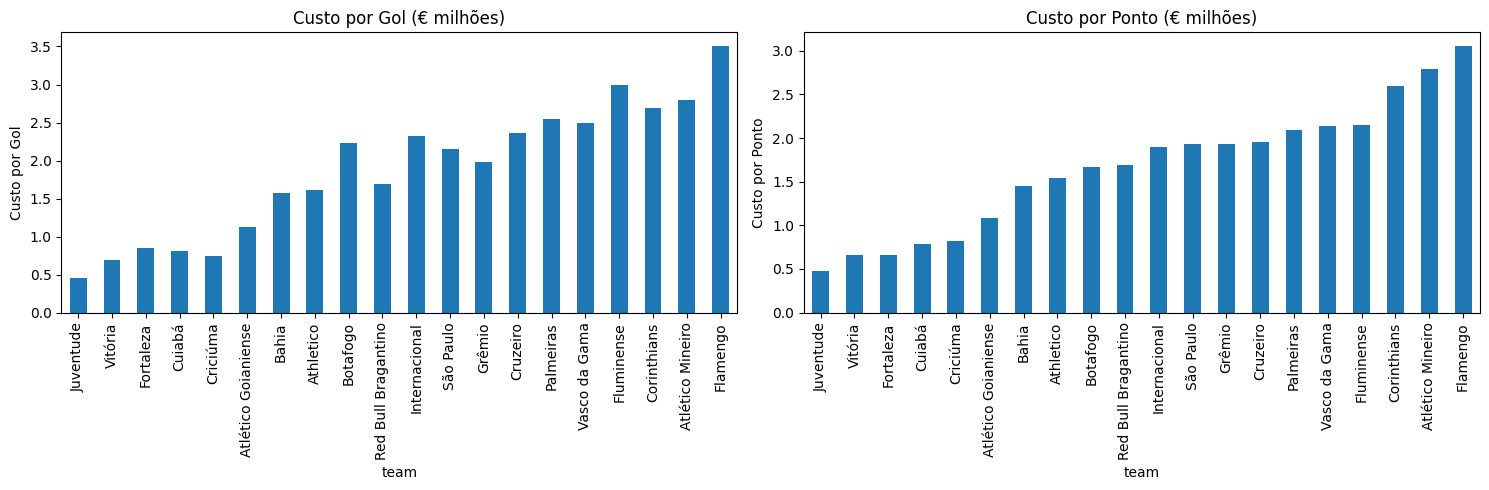

,team,Custo por Gol (€),Custo por Ponto (€)
14,Juventude,0.450000,0.480000
10,Vitória,0.688889,0.659574
3,Fortaleza,0.850000,0.662500
19,Cuiabá,0.809655,0.782667
17,Criciúma,0.738095,0.815789
18,Atlético Goianiense,1.124138,1.086667
7,Bahia,1.570408,1.451887
16,Athletico,1.615000,1.538095
0,Botafogo,2.227627,1.663671
15,Red Bull Bragantino,1.687500,1.687500


In [13]:
# Calcular custo por gol e custo por ponto
df['Custo por Gol (€)'] = df['Valor de Mercado (€)'] / df['GF']
df['Custo por Ponto (€)'] = df['Valor de Mercado (€)'] / df['Pts']

# Gráficos para comparar os custos
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico de custo por gol
df.plot(kind='bar', x='team', y='Custo por Gol (€)', ax=axes[0], legend=False)
axes[0].set_title('Custo por Gol (€ milhões)')
axes[0].set_ylabel('Custo por Gol')

# Gráfico de custo por ponto
df.plot(kind='bar', x='team', y='Custo por Ponto (€)', ax=axes[1], legend=False)
axes[1].set_title('Custo por Ponto (€ milhões)')
axes[1].set_ylabel('Custo por Ponto')

plt.tight_layout()
plt.show()

# Exibir os dados calculados
df[['team', 'Custo por Gol (€)', 'Custo por Ponto (€)']]

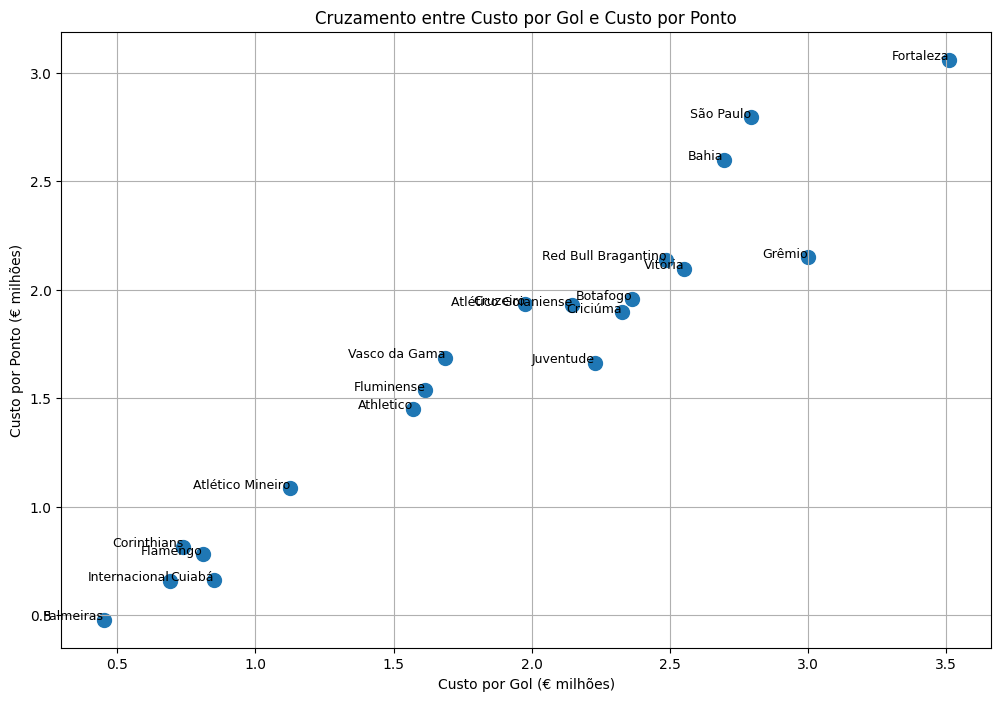

In [14]:
# Criar um gráfico de dispersão cruzando Custo por Gol e Custo por Ponto
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['Custo por Gol (€)'], df['Custo por Ponto (€)'], s=100)

# Adicionar rótulos aos pontos
for i, team in enumerate(df['team']):
    plt.text(df['Custo por Gol (€)'][i], df['Custo por Ponto (€)'][i], team, fontsize=9, ha='right')


# Adicionar título e rótulos
plt.title('Cruzamento entre Custo por Gol e Custo por Ponto')
plt.xlabel('Custo por Gol (€ milhões)')
plt.ylabel('Custo por Ponto (€ milhões)')

# Exibir o gráfico
plt.grid(True)
plt.show()

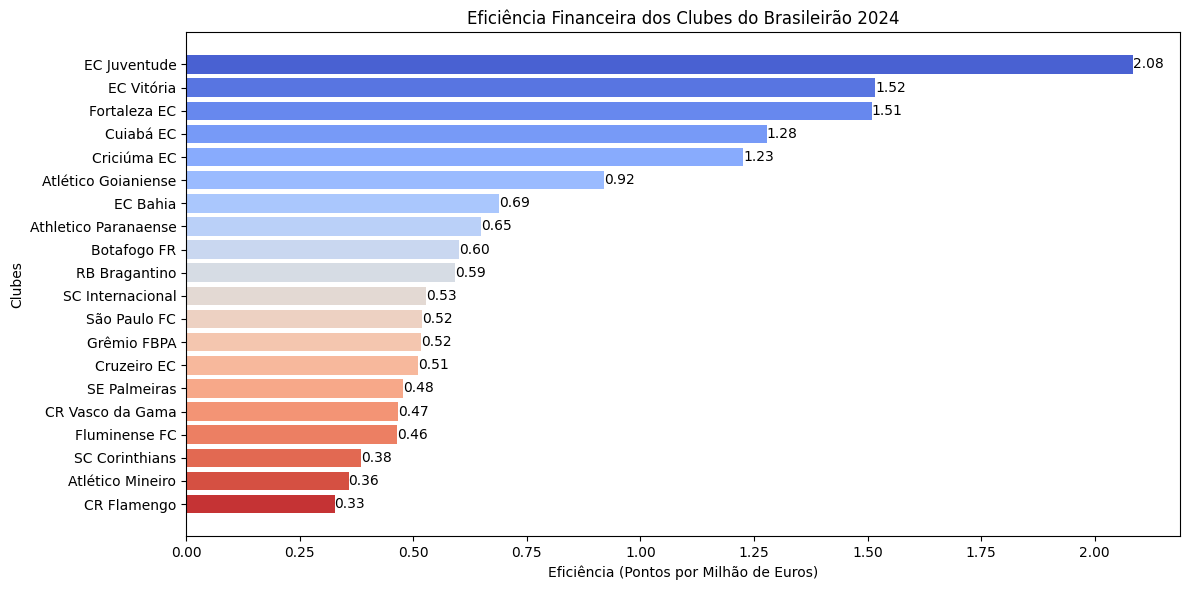

In [15]:
# Criar uma paleta de cores baseada na eficiência
cores = sns.color_palette("coolwarm", len(df))

# Gerar o gráfico com cores variadas
plt.figure(figsize=(12, 6))
bars = plt.barh(df['team_mapeado_fuzzy'], df['eficiencia'], color=cores)
plt.barh(df['team_mapeado_fuzzy'], df['eficiencia'], color=cores)
plt.xlabel('Eficiência (Pontos por Milhão de Euros)')
plt.ylabel('Clubes')
plt.title('Eficiência Financeira dos Clubes do Brasileirão 2024')

# Adicionar anotações em cada barra
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.2f}', va='center')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [16]:
correlacao = df[['Pts', 'Valor de Mercado (€)']].corr()
print("Correlação entre Pontos e Valor de Mercado:")
print(correlacao)

Correlação entre Pontos e Valor de Mercado:
                           Pts  Valor de Mercado (€)
Pts                   1.000000              0.691706
Valor de Mercado (€)  0.691706              1.000000


Correlação positiva (0.691): Isso sugere que, em geral, clubes com maior valor de mercado tendem a conquistar mais pontos, mas essa relação não é perfeita.

Correlação moderada: Embora exista uma tendência positiva, outros fatores além do valor de mercado influenciam os pontos conquistados (como a gestão, técnico, planejamento e desempenho dos jogadores em campo).

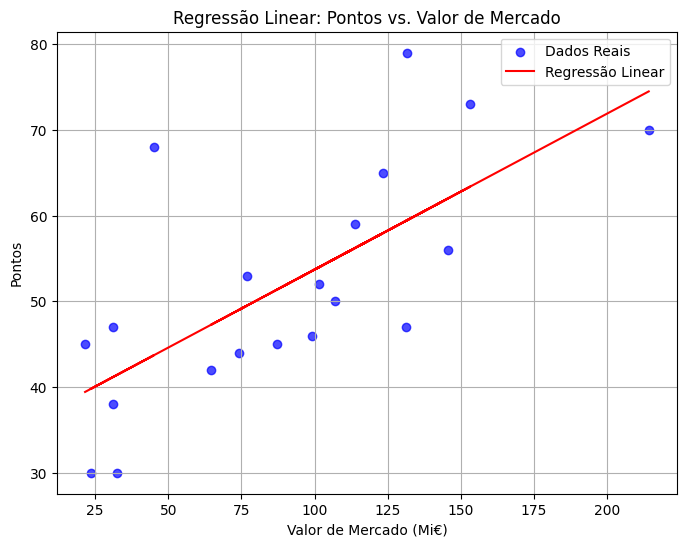

Coeficiente da Regressão: 0.18
Intercepto: 35.49


In [17]:
# Preparar os dados
X = df[['Valor de Mercado (€)']].values
y = df['Pts'].values

# Ajustar o modelo de regressão linear
modelo = LinearRegression()
modelo.fit(X, y)

# Fazer previsões
y_pred = modelo.predict(X)

# Plotar os resultados
plt.figure(figsize=(8, 6))
plt.scatter(X, y, color='blue', alpha=0.7, label='Dados Reais')
plt.plot(X, y_pred, color='red', label='Regressão Linear')
plt.title('Regressão Linear: Pontos vs. Valor de Mercado')
plt.xlabel('Valor de Mercado (Mi€)')
plt.ylabel('Pontos')
plt.legend()
plt.grid(True)
plt.show()

print(f"Coeficiente da Regressão: {modelo.coef_[0]:.2f}")
print(f"Intercepto: {modelo.intercept_:.2f}")

In [18]:
r2 = modelo.score(X, y)
print(f"R²: {r2:.2f}")

R²: 0.48


O valor de R² = 0.48 indica que o modelo de regressão linear explica 48% da variação nos pontos dos clubes com base no valor de mercado. Isso sugere que o valor de mercado tem alguma influência no desempenho dos clubes, mas 52% da variação nos pontos é explicada por outros fatores.

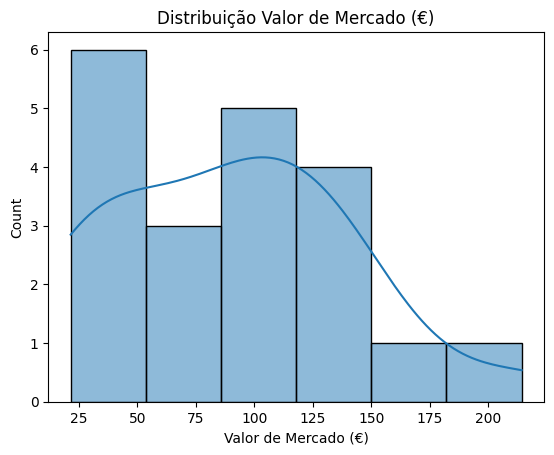

In [19]:
sns.histplot(df['Valor de Mercado (€)'], kde=True)
plt.title('Distribuição Valor de Mercado (€)')
plt.show()


**Análise do Gráfico no Contexto da Série A**
1. **Distribuição Concentrada**:
   - A maioria dos times da Série A possui valores de mercado entre **25 e 125 milhões de euros**.
   - Essa concentração reflete a realidade do futebol brasileiro, onde grande parte dos clubes têm orçamentos mais modestos em comparação com clubes europeus.

2. **Cauda Direita (Right-Skewed)**:
   - A presença de clubes com valores de mercado acima de **150 milhões de euros** é rara.
   - Provavelmente esses valores correspondem a times de elite do Brasileirão, como **Flamengo**, **Palmeiras**, ou **Atlético-MG**, que possuem elencos mais valiosos devido a maiores investimentos.

3. **Multimodalidade**:
   - O pico entre **25 e 50 milhões** representa clubes com elencos de menor valor, como equipes recém-promovidas ou que focam em elencos mais jovens e baratos.
   - O segundo pico, entre **100 e 125 milhões**, provavelmente corresponde aos clubes com maior poder financeiro e que investem pesado em contratações e salários.

---
**Interpretação do Cenário**
- **Clubes na Base da Distribuição (25-50 milhões)**:
  - Exemplos podem incluir times como **Cuiabá**, **Atlético-GO**, ou outros que tradicionalmente possuem elencos menos valiosos.
  - Esses clubes geralmente apostam mais em jogadores jovens, revelações ou empréstimos.

- **Clubes na Faixa Intermediária (75-125 milhões)**:
  - Aqui podem estar clubes como **Bahia**, **Fortaleza**, **Corinthians**, ou **Internacional**.
  - São equipes que misturam investimentos em jogadores mais experientes com formação de talentos.

- **Clubes no Topo (>150 milhões)**:
  - Times como **Flamengo**, **Palmeiras**, e talvez **Atlético-MG**, que possuem maior investimento em elencos e frequentemente disputam títulos.


### Mapa de correlacao do Valor de mercado com metricas chaves

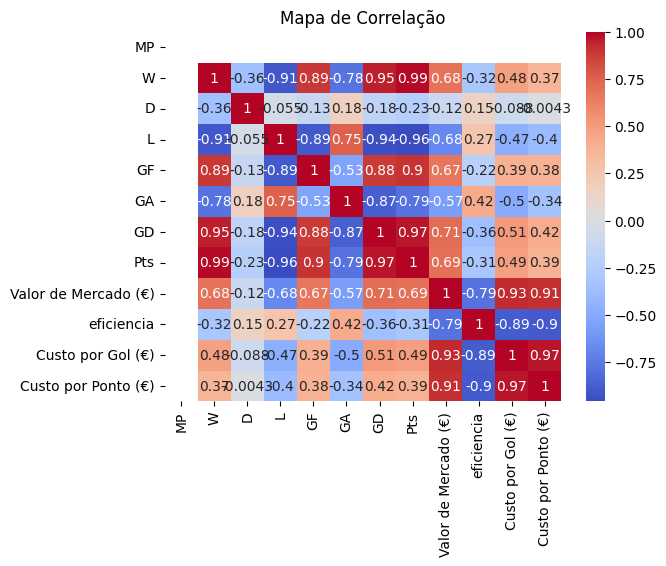

In [20]:
# Calculate correlation only for numeric columns
correlation = df.select_dtypes(include=np.number).corr()

# Plot the heatmap using seaborn
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Mapa de Correlação')
plt.show()



Análise de Variáveis-Chave:
- Vitórias (W)
  - Correlação positiva muito alta com:
    - Saldo de Gols (GD): 0.95
    - Pontos (Pts): 0.99
    - Gols Marcados (GF): 0.89
  -Faz sentido, já que times que vencem mais tendem a ter mais gols e saldo positivo.

- Gols Marcados (GF)

  - Alta correlação com:
    - Vitórias (W): 0.89
    - Saldo de Gols (GD): 0.88
  - Menor correlação com:
    - Eficiência: 0.22
  - Sugere que marcar gols ajuda no desempenho geral, mas a eficiência envolve outros fatores.

- Derrotas (L)

  - Correlação negativa forte com:
    - Pontos (Pts): -0.96
    - Vitórias (W): -0.91
    - Saldo de Gols (GD): -0.94
  - Mostra que mais derrotas estão fortemente associadas a um desempenho geral ruim.

- Eficiência

  - Correlação negativa forte com:
    - Valor de mercado : -0.79
  - Baixa ou moderada correlação com outras variáveis, indicando que a eficiência combina múltiplos fatores além de gols e vitórias

### Encontrar padrões e grupos semelhantes entre os times do Brasileirão 2024 baseado em ('GF', 'GA', 'Valor de Mercado (€)', 'Pts', 'eficiencia')



In [21]:
# Padronizar os dados para clusterização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['GF', 'GA', 'Valor de Mercado (€)','Pts','eficiencia']])

# Definir e ajustar o modelo K-Means
kmeans = KMeans(n_clusters=4, init='random', random_state=42)
clusters = kmeans.fit_predict(X_scaled)

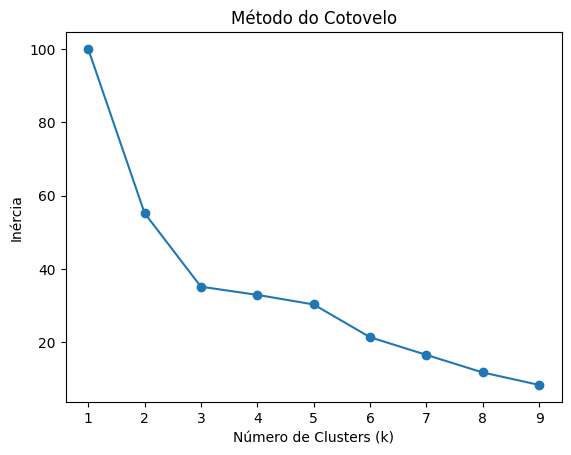

In [22]:
#Avaliar o Número de Clusters
inertia = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo')
plt.show()

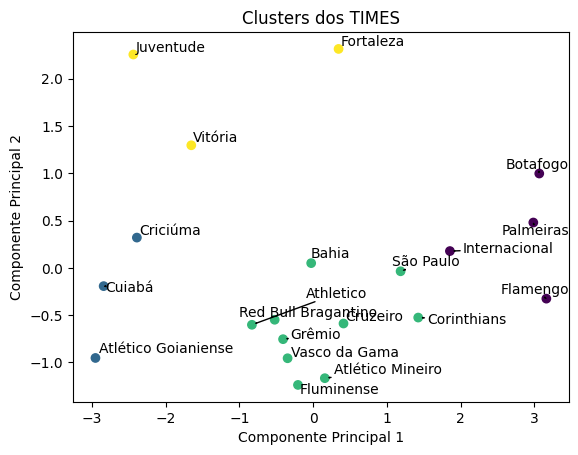

In [23]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.title('Clusters dos TIMES')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

# Adicionar o nome dos times
texts = []
for i, txt in enumerate(df['team']):  # Assuming 'team' column has team names
    texts.append(plt.text(X_pca[i, 0], X_pca[i, 1], txt))

# Para nao sobrepor
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black'))

plt.show()

---

### **1. Interpretação de Clusters**
#### **Cluster 1 (Amarelo):**
- **Times:** Atlético-MG, Vasco da Gama, Grêmio, Cruzeiro, Red Bull Bragantino.
- **Perfil:** Times com desempenho intermediário:
  - Provavelmente não se destacam nem ofensiva nem defensivamente.
  - Podem ser times estáveis, mas sem um grande diferencial em pontos ou eficiência.
- **Insight:** Esses times podem precisar de melhorias específicas para se destacarem, como ajustes táticos ou reforços no elenco.

#### **Cluster 2 (Roxo):**
- **Times:** Juventude, Vitória.
- **Perfil:** Times de baixa performance:
  - Possivelmente sofrem muitos gols (alta vulnerabilidade defensiva) e marcam poucos gols.
  - Menor eficiência ou baixo investimento pode ser um fator.
- **Insight:** Esses times lutariam contra o rebaixamento e precisam focar em fortalecer tanto o ataque quanto a defesa.

#### **Cluster 3 (Verde):**
- **Times:** Fortaleza, Internacional, São Paulo, Corinthians, Bahia, Botafogo, Flamengo, Palmeiras.
- **Perfil:** Times de alto desempenho:
  - Provavelmente lideram em eficiência, gols marcados, e pontos obtidos.
  - Podem representar os principais concorrentes por títulos ou classificações em competições internacionais.
- **Insight:** Esses times podem focar em detalhes táticos para manter sua posição de destaque.

#### **Cluster 4 (Azul Claro):**
- **Times:** Fluminense.
- **Perfil:** Um outlier:
  - Fluminense parece se comportar de forma distinta em relação aos outros grupos. Pode indicar uma combinação única de características (e.g., alta eficiência ofensiva, mas defesa mais fraca ou desempenho muito equilibrado).
- **Insight:** O time pode ter um estilo de jogo peculiar ou estar em transição para um grupo de maior desempenho.

---

### **2. Posições no Gráfico**
- **Eixo X (Componente Principal 1):**
- **Interpretação Atualizada:**
  - Componente Principal 1 foi descrito como fortemente influenciado por:
    - **Pts (peso 0.7):** Desempenho geral (pontuação no campeonato).
    - **Valor de Mercado (€) (peso 0.5):** Indicador financeiro e potencial econômico do time.
    - **GF (peso 0.6):** Capacidade ofensiva (gols marcados).
  - Portanto, o **Eixo X (CP1)** reflete a **capacidade geral do time** em termos de **desempenho ofensivo e impacto financeiro**. Times à direita no gráfico (valores altos) são mais competitivos, com maior pontuação, investimento e desempenho ofensivo.

- **Eixo Y (Componente Principal 2):**
- **Interpretação Atualizada:**
  - Componente Principal 2 foi descrito como fortemente influenciado por:
    - **GA (peso 0.8):** Gols sofridos, indicando vulnerabilidade defensiva.
    - **Eficiência (peso 0.6):** Capacidade do time de converter oportunidades.
    - Influência negativa de **GF (peso -0.3):** Muitos gols marcados podem reduzir o valor de CP2 em certos contextos.
  - O **Eixo Y (CP2)**, portanto, mede o **equilíbrio defensivo e eficiência**:
    - Valores altos no eixo Y indicam times com sólida defesa e boa eficiência.
    - Valores baixos indicam vulnerabilidades defensivas ou dependência de um ataque prolífico, mas ineficiente.

---

### **3. Relação entre Times e Clusters**
- **Botafogo, Flamengo, Palmeiras:** Estão bem posicionados no cluster de alto desempenho (verde), indicando consistência e potencial liderança no campeonato.
- **Bahia e São Paulo:** Próximos no gráfico, podem compartilhar características como eficiência intermediária e potencial competitivo.
- **Juventude e Vitória:** Bem distantes do restante dos clusters, mostrando que estão em um nível muito diferente em relação à média da competição.

---

### **4. Insights Gerais**
- **Fortaleza como destaque:** Isolado no cluster verde, o Fortaleza demonstra ser um time que combina características defensivas e ofensivas sólidas, possivelmente com bom investimento.
- **Fluminense como único em seu cluster:** Pode ser um time em transição, dependendo de reforços para atingir o nível dos melhores ou caindo para um desempenho médio.
- **Juventude e Vitória precisam de atenção:** Esses times têm o maior risco de cair de divisão se os problemas defensivos e ofensivos não forem corrigidos.


#4.1 Analisar correlacao somente com metricas ofensivas.
    - Comparar a previsao de pontos com a tabela final Real

In [24]:
# Selecionar apenas as colunas numéricas para calcular a correlação
numeric_columns = merged_df.select_dtypes(include=np.number).columns
correlation_matrix = merged_df[numeric_columns].corr()
# Remover colunas e linhas com valores NaN
cleaned_correlation_matrix = correlation_matrix.dropna(axis=0, how='all').dropna(axis=1, how='all')

# Exibir a matriz de correlação
print(cleaned_correlation_matrix)

                                W         D         L        GF        GA  \
W                        1.000000 -0.360947 -0.911454  0.886279 -0.779556   
D                       -0.360947  1.000000 -0.054682 -0.133885  0.181363   
L                       -0.911454 -0.054682  1.000000 -0.889861  0.754650   
GF                       0.886279 -0.133885 -0.889861  1.000000 -0.532827   
GA                      -0.779556  0.181363  0.754650 -0.532827  1.000000   
GD                       0.952868 -0.179344 -0.941104  0.882133 -0.868596   
Pts                      0.991041 -0.233163 -0.958233  0.904978 -0.786895   
players_used_           -0.115898 -0.052184  0.147111 -0.101580  0.112066   
Age_                    -0.008635 -0.057785  0.034737 -0.136063  0.011522   
Poss_                    0.405711 -0.177758 -0.355972  0.344257 -0.435848   
Performance_Gls          0.840933 -0.118203 -0.848228  0.978095 -0.504276   
Performance_Ast          0.777579 -0.132652 -0.774022  0.854994 -0.417668   

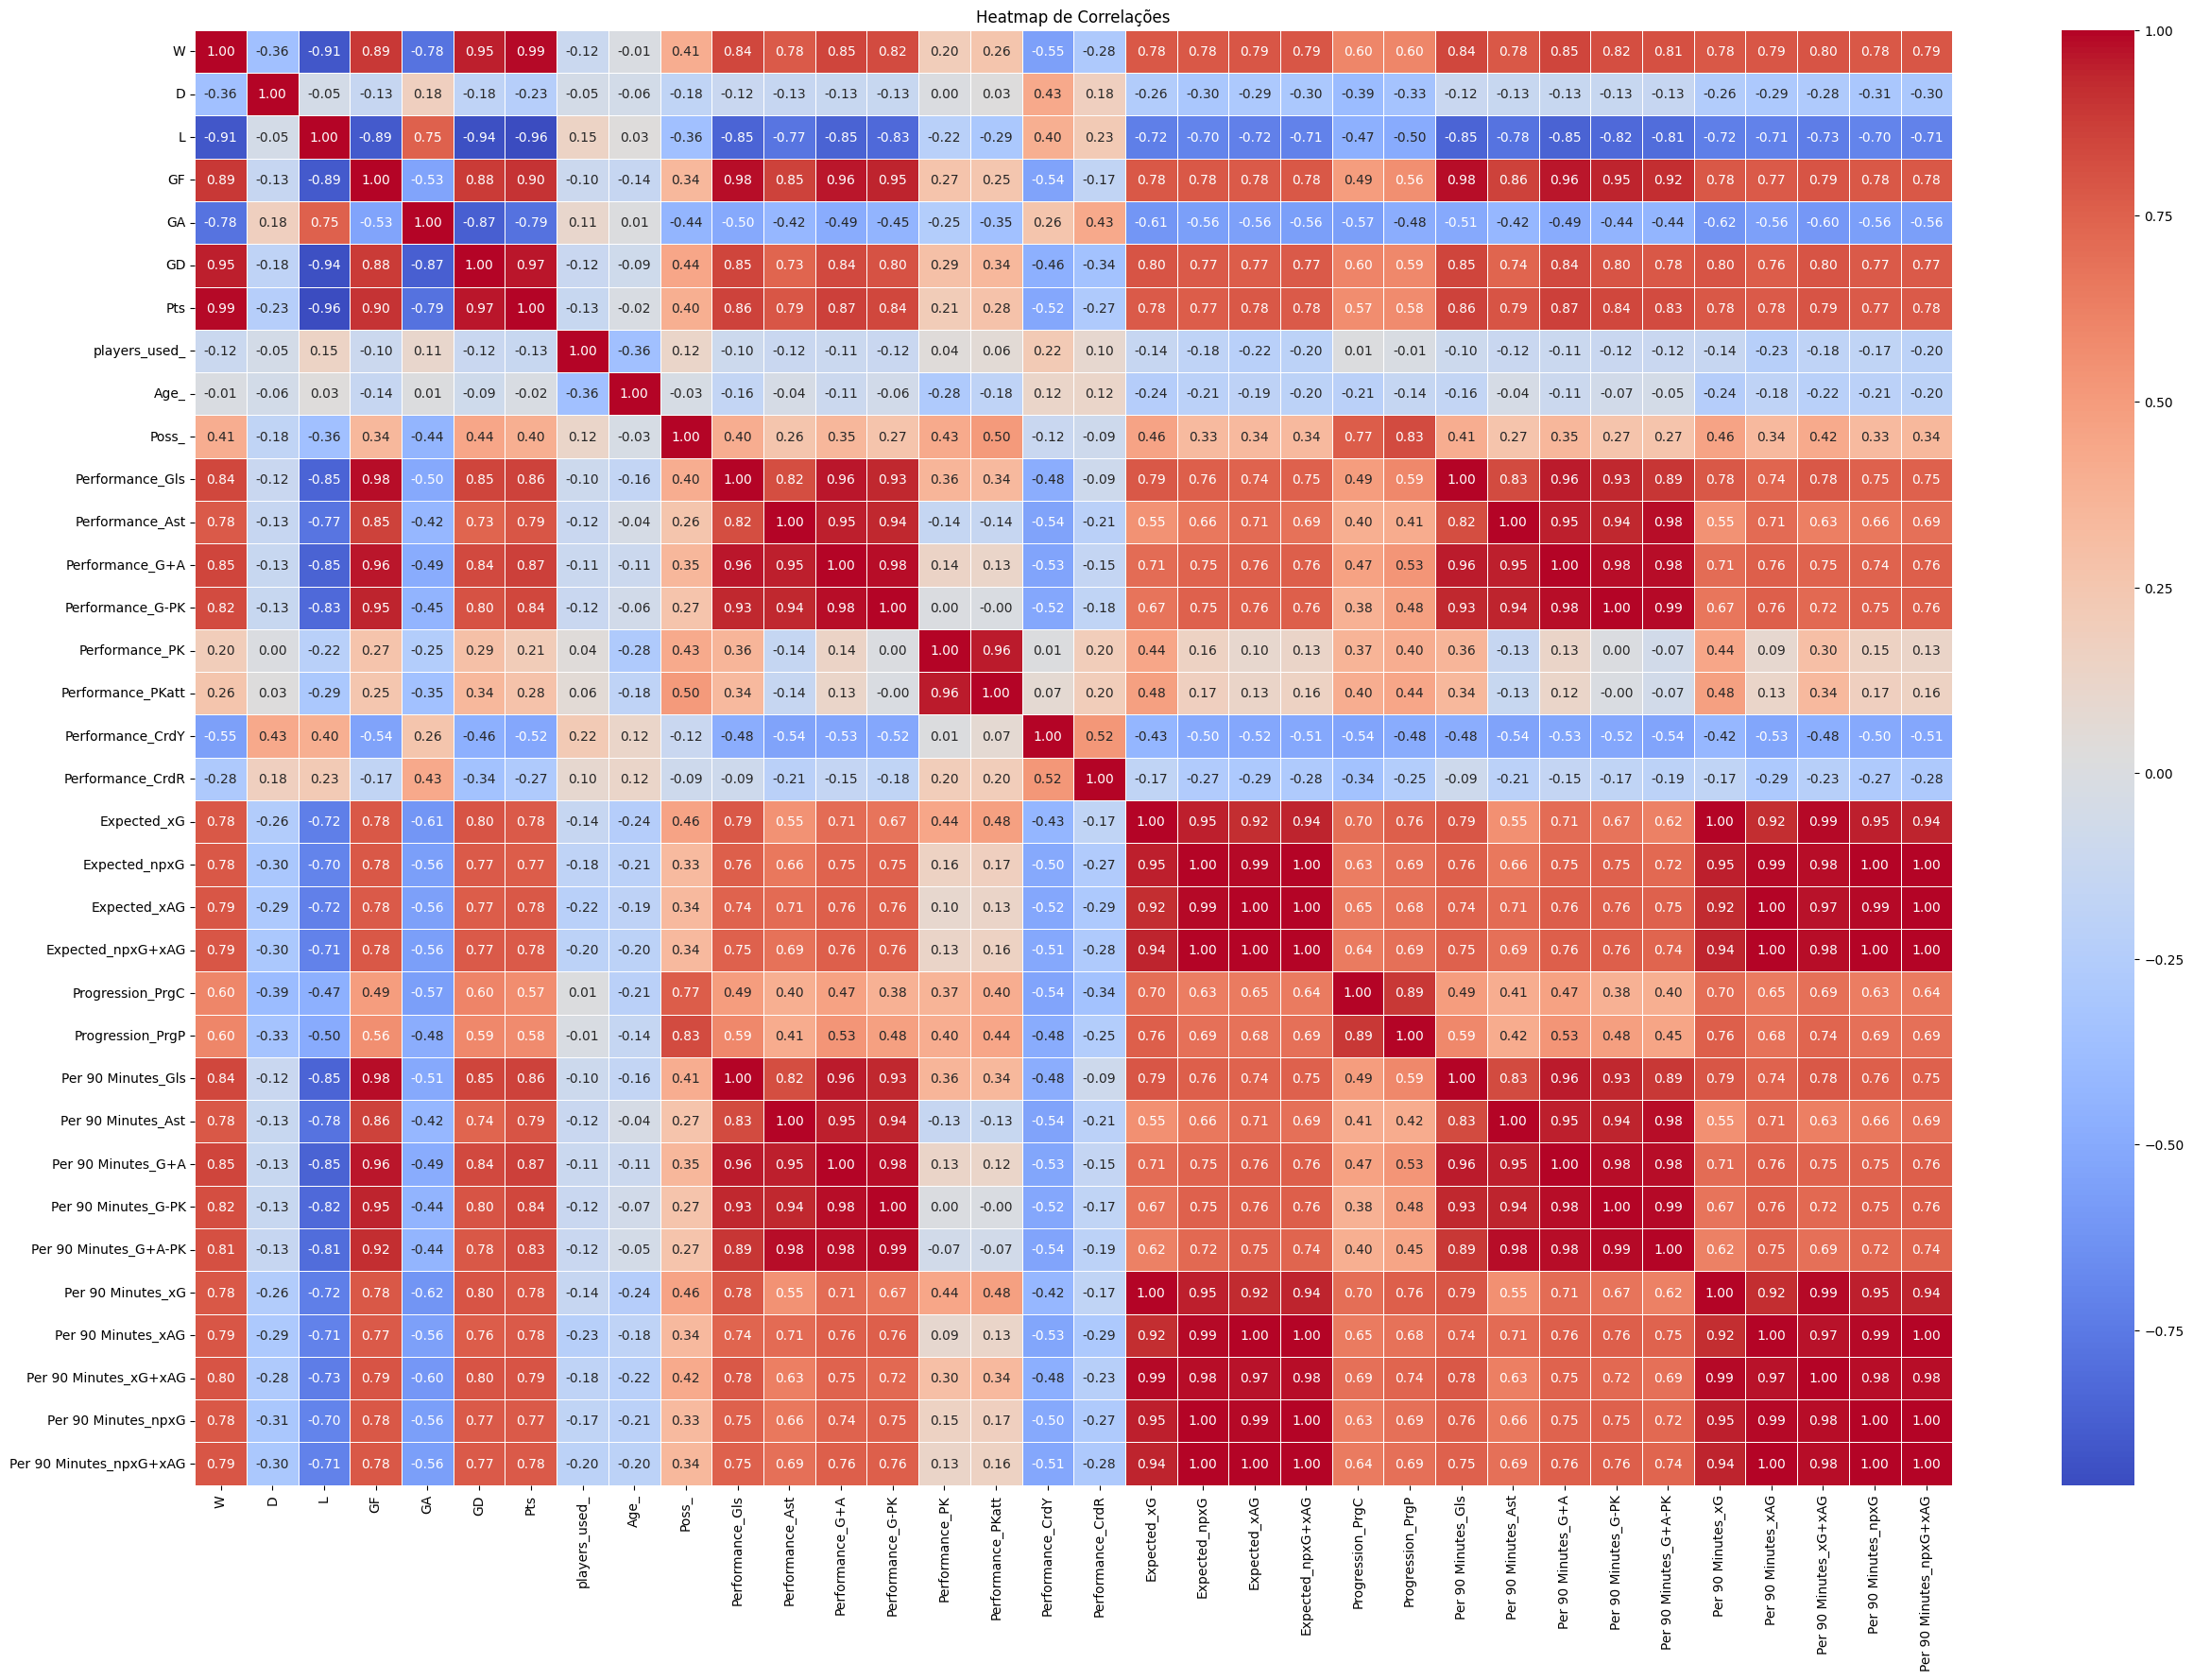

In [25]:
plt.figure(figsize=(30, 20))  # Define o tamanho da figura
sns.heatmap(cleaned_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap de Correlações')
plt.show()

#### Analise das correlacoes

### 1. **Análise da Posse de Bola e Eficiência**
   - A posse de bola ("Poss_") apresenta **correlações moderadas** com métricas ofensivas, como:
     - **"Expected_xG" (0.48)**: Equipes com maior posse tendem a criar mais oportunidades de gols esperados, mas o impacto não é absoluto.
     - **"Performance_Gls" (0.41)**: A posse contribui para gols, mas o valor moderado sugere que apenas ter a bola não garante eficiência ofensiva. Estratégias de ataque direto podem ser mais eficazes.
   - **Conclusão:** Posse de bola por si só não é um indicativo absoluto de sucesso, mas é uma base para a criação de chances.

---

### 2. **Impacto dos Cartões no Desempenho**
   - "Total_Cards_" tem:
     - **Correlação negativa com "Pts" (-0.49)** e "W" (-0.54)**: Mais cartões impactam levemente o número de vitórias e pontos.
     - **Correlação positiva com "L" (0.36)**: Indica que equipes mais indisciplinadas podem ter maior probabilidade de perder jogos.
   - **Conclusão:** A disciplina é um fator relevante para o desempenho geral. Equipes que evitam cartões tendem a ser mais competitivas.

---

### 3. **Gols Marcados e Gols Esperados**
   - "GF" (Gols a favor) tem **alta correlação com "Expected_xG" (0.88)**:
     - Isso reflete que, em geral, times convertem bem suas chances de gol criadas.
     - A análise da eficiência ofensiva entre as equipes poderia considerar times que convertem mais gols do que o esperado (overperformance) ou menos (underperformance).
   - **Conclusão:** A eficiência ofensiva é crucial, especialmente para times que precisam maximizar chances em partidas equilibradas.

---

### 4. **Saldo de Gols como Métrica Global de Sucesso**
   - "GD" (Saldo de Gols) está fortemente correlacionado com:
     - **"Pts" (0.85):** Times com saldo positivo acumulam mais pontos.
     - **"W" (0.79):** Vitórias resultam em bom saldo de gols.
     - **"L" (-0.78):** Derrotas prejudicam o saldo de gols.
   - **Conclusão:** O saldo de gols é um resumo eficiente de desempenho geral, combinando tanto a força ofensiva quanto a solidez defensiva.

---

### 5. **Performance Defensiva**
   - "GA" (Gols Contra) apresenta:
     - **Correlação negativa com "Pts" (-0.65)** e "W" (-0.61)**: Sofrer menos gols é um fator crítico para a conquista de pontos e vitórias.
     - **Correlação positiva com "L" (0.60):** Equipes que sofrem mais gols têm maior tendência a perder jogos.
   - **Conclusão:** A solidez defensiva é tão importante quanto a eficiência ofensiva. Times campeões costumam ser equilibrados nessas duas frentes.

---

### 6. **Evolução Tática e Idade dos Jogadores**
   - "Age" (idade média do elenco):
     - **Correlação baixa com "Pts" (0.12):** Não há impacto claro da idade média no desempenho geral.
   - "players_used" (número de jogadores utilizados):
     - **Correlação leve com "L" (0.17):** Indica que times que utilizam muitos jogadores podem estar enfrentando dificuldades, como lesões ou falta de consistência.
   - **Conclusão:** Equipes mais consistentes (com menos mudanças) podem ser mais bem-sucedidas.

---

### 7. **Eficiência Combinada (Eficiencia_Combinada)**
   - Essa métrica parece ser uma síntese de outros indicadores. Tem alta correlação com:
     - **"Pts" (0.88):** Confirma que times com alta eficiência combinada são bem-sucedidos no campeonato.
     - **"W" (0.83):** Relaciona-se diretamente com as vitórias.
   - **Conclusão:** A eficiência combinada é um excelente indicador de desempenho geral, englobando tanto aspectos ofensivos quanto defensivos.

---

### 8. **Métricas Por 90 Minutos**
   - Variáveis ajustadas por 90 minutos, como "Per 90 Minutes_Gls" e "Per 90 Minutes_xG," mostram correlações muito próximas de suas métricas absolutas.
   - **Benefício dessas métricas:** Permitem uma análise mais justa entre equipes com diferentes tempos de jogo (e.g., times com muitas prorrogações ou jogos desbalanceados).


   Performance_Gls  Expected_xG  Gls_xG_diff  Performance_Ast  Expected_xAG  \
0               58         57.3          0.7               41          41.1   
1               58         67.0         -9.0               35          47.4   
2               60         56.4          3.6               42          38.9   
3               51         43.6          7.4               38          31.6   
4               52         58.4         -6.4               33          40.1   

   Ast_xAG_diff  
0          -0.1  
1         -12.4  
2           3.1  
3           6.4  
4          -7.1  


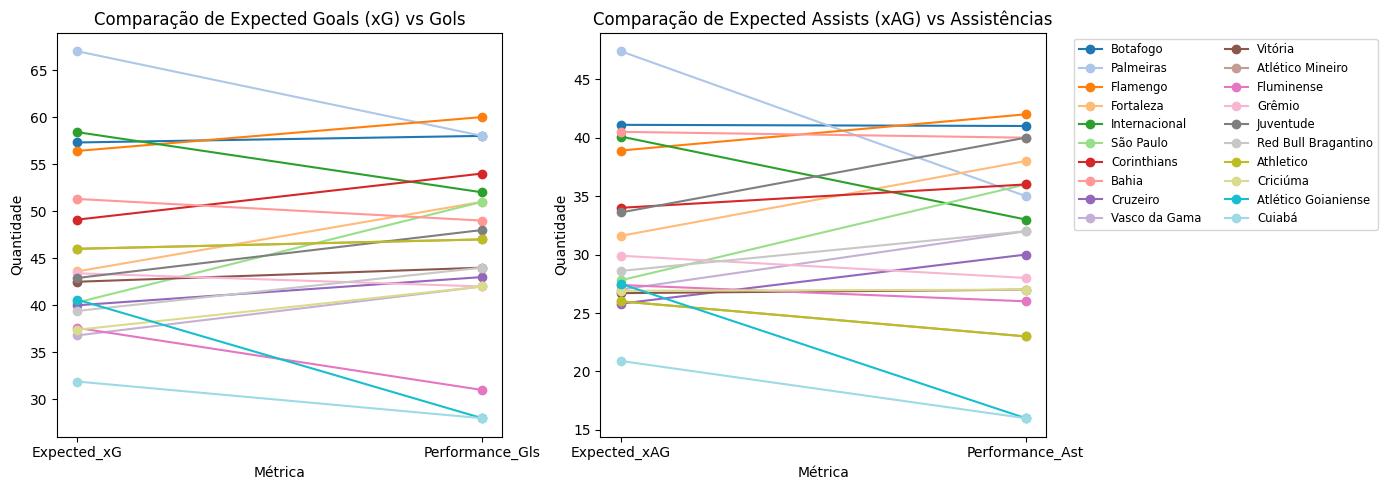

In [26]:
# Calcular as diferenças entre valores reais e esperados
merged_df['Gls_xG_diff'] = merged_df['Performance_Gls'] - merged_df['Expected_xG']
merged_df['Ast_xAG_diff'] = merged_df['Performance_Ast'] - merged_df['Expected_xAG']

# Exibir uma amostra do DataFrame para conferência
print(merged_df[['Performance_Gls', 'Expected_xG', 'Gls_xG_diff', 'Performance_Ast', 'Expected_xAG', 'Ast_xAG_diff']].head())

# Criar um mapeamento único de cores para cada time
teams = merged_df['team'].unique()
colors = cm.tab20(np.linspace(0, 1, len(teams)))  # Usando um colormap com até 20 cores distintas
color_map = {team: color for team, color in zip(teams, colors)}

plt.figure(figsize=(14, 5))

# Subplot 1: Gols vs xG
plt.subplot(1, 2, 1)
for i, row in merged_df.iterrows():
    plt.plot(['Expected_xG', 'Performance_Gls'],
             [row['Expected_xG'], row['Performance_Gls']],
             marker='o',
             color=color_map[row['team']],
             label=row['team'])

plt.title('Comparação de Expected Goals (xG) vs Gols')
plt.xlabel('Métrica')
plt.ylabel('Quantidade')

# Subplot 2: Assistências vs xAG
plt.subplot(1, 2, 2)
for i, row in merged_df.iterrows():
    plt.plot(['Expected_xAG', 'Performance_Ast'],
             [row['Expected_xAG'], row['Performance_Ast']],
             marker='o',
             color=color_map[row['team']],
             label=row['team'])

plt.title('Comparação de Expected Assists (xAG) vs Assistências')
plt.xlabel('Métrica')
plt.ylabel('Quantidade')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)  # Adicionar legenda externa com 2 colunas

plt.tight_layout()
plt.show()

Interpretação dos Resultados
- Gols e Assistências Acima das Expectativas: Se a diferença for positiva, o time está superando as expectativas.

- Gols e Assistências Abaixo das Expectativas: Se a diferença for negativa, o desempenho está abaixo do esperado.

In [27]:
# Calcular eficiência ofensiva: Gols / xG
merged_df['Eficiencia_Ofensiva'] = merged_df['Performance_Gls'] / merged_df['Expected_xG']

# Exibir a eficiência ofensiva
print(merged_df[['team','Performance_Gls', 'Expected_xG', 'Eficiencia_Ofensiva']])

                   team  Performance_Gls  Expected_xG  Eficiencia_Ofensiva
0              Botafogo               58         57.3             1.012216
1             Palmeiras               58         67.0             0.865672
2              Flamengo               60         56.4              1.06383
3             Fortaleza               51         43.6             1.169725
4         Internacional               52         58.4             0.890411
5             São Paulo               51         40.3             1.265509
6           Corinthians               54         49.1             1.099796
7                 Bahia               49         51.3             0.955166
8              Cruzeiro               43         40.0                1.075
9         Vasco da Gama               42         36.8             1.141304
10              Vitória               44         42.5             1.035294
11     Atlético Mineiro               47         46.0             1.021739
12           Fluminense  

In [28]:
# Calcular eficiência de assistências: Assistências / xAG
merged_df['Eficiencia_Assistencias'] = merged_df['Performance_Ast'] / merged_df['Expected_xAG']

# Exibir a eficiência de assistências
print(merged_df[['team','Performance_Ast', 'Expected_xAG', 'Eficiencia_Assistencias']])

                   team  Performance_Ast  Expected_xAG  \
0              Botafogo               41          41.1   
1             Palmeiras               35          47.4   
2              Flamengo               42          38.9   
3             Fortaleza               38          31.6   
4         Internacional               33          40.1   
5             São Paulo               36          27.8   
6           Corinthians               36          34.0   
7                 Bahia               40          40.5   
8              Cruzeiro               30          25.8   
9         Vasco da Gama               32          27.0   
10              Vitória               27          26.7   
11     Atlético Mineiro               23          26.0   
12           Fluminense               26          27.4   
13               Grêmio               28          29.9   
14            Juventude               40          33.6   
15  Red Bull Bragantino               32          28.6   
16            

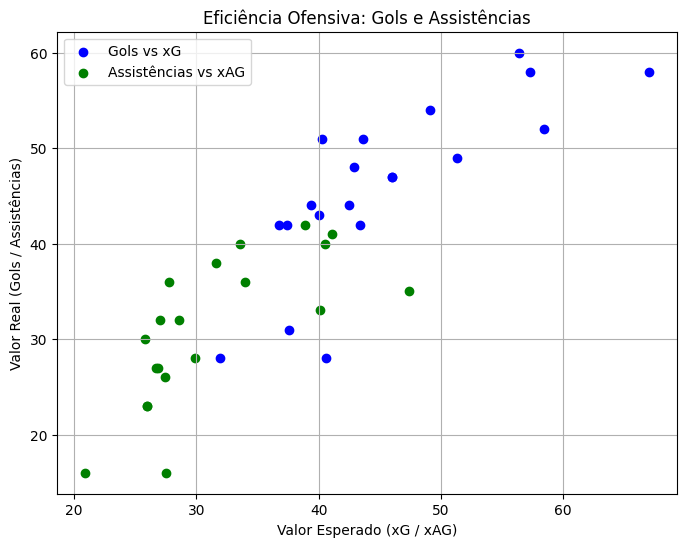

In [29]:
plt.figure(figsize=(8, 6))

# Scatter plot para eficiência ofensiva
plt.scatter(merged_df['Expected_xG'], merged_df['Performance_Gls'], color='blue', label='Gols vs xG')
plt.scatter(merged_df['Expected_xAG'], merged_df['Performance_Ast'], color='green', label='Assistências vs xAG')

plt.xlabel('Valor Esperado (xG / xAG)')
plt.ylabel('Valor Real (Gols / Assistências)')
plt.title('Eficiência Ofensiva: Gols e Assistências')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# Diferença percentual para Gols
merged_df['Diff_Percent_Gols'] = ((merged_df['Performance_Gls'] - merged_df['Expected_xG']) / merged_df['Expected_xG']) * 100

# Diferença percentual para Assistências
merged_df['Diff_Percent_Assist'] = ((merged_df['Performance_Ast'] - merged_df['Expected_xAG']) / merged_df['Expected_xAG']) * 100

# Exibir as diferenças percentuais
print(merged_df[['team','Diff_Percent_Gols', 'Diff_Percent_Assist']])

                   team  Diff_Percent_Gols  Diff_Percent_Assist
0              Botafogo            1.22164            -0.243309
1             Palmeiras         -13.432836           -26.160338
2              Flamengo           6.382979             7.969152
3             Fortaleza          16.972477            20.253165
4         Internacional         -10.958904           -17.705736
5             São Paulo          26.550868            29.496403
6           Corinthians           9.979633             5.882353
7                 Bahia          -4.483431            -1.234568
8              Cruzeiro                7.5             16.27907
9         Vasco da Gama          14.130435            18.518519
10              Vitória           3.529412             1.123596
11     Atlético Mineiro           2.173913           -11.538462
12           Fluminense         -17.553191            -5.109489
13               Grêmio          -3.225806            -6.354515
14            Juventude          11.8881

In [31]:
# Identificar outliers em Gols vs xG
outliers_gols = merged_df[merged_df['Gls_xG_diff'].abs() > 5]
print("Times com desempenho fora da curva em Gols:")
print(outliers_gols[['team','Performance_Gls', 'Expected_xG', 'Gls_xG_diff']])

# Identificar outliers em Assistências vs xAG
outliers_assists = merged_df[merged_df['Ast_xAG_diff'].abs() > 5]
print("\nTimes com desempenho fora da curva em Assistências:")
print(outliers_assists[['team','Performance_Ast', 'Expected_xAG', 'Ast_xAG_diff']])

Times com desempenho fora da curva em Gols:
                   team  Performance_Gls  Expected_xG  Gls_xG_diff
1             Palmeiras               58         67.0         -9.0
3             Fortaleza               51         43.6          7.4
4         Internacional               52         58.4         -6.4
5             São Paulo               51         40.3         10.7
9         Vasco da Gama               42         36.8          5.2
12           Fluminense               31         37.6         -6.6
14            Juventude               48         42.9          5.1
18  Atlético Goianiense               28         40.6        -12.6

Times com desempenho fora da curva em Assistências:
                   team  Performance_Ast  Expected_xAG  Ast_xAG_diff
1             Palmeiras               35          47.4         -12.4
3             Fortaleza               38          31.6           6.4
4         Internacional               33          40.1          -7.1
5             São Paulo 

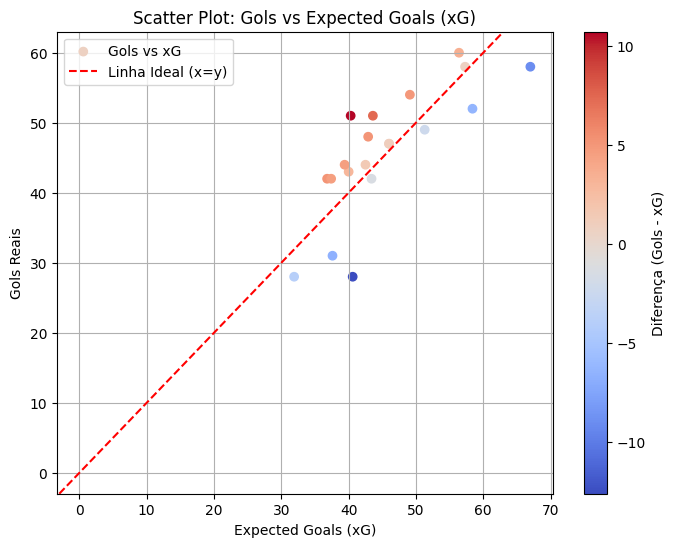

In [32]:
# Calcular a diferença entre Gols e xG
merged_df['Gls_xG_diff'] = merged_df['Performance_Gls'] - merged_df['Expected_xG']

# Scatter plot com coloração baseada na diferença
plt.figure(figsize=(8, 6))
scatter = plt.scatter(merged_df['Expected_xG'], merged_df['Performance_Gls'],
                      c=merged_df['Gls_xG_diff'], cmap='coolwarm', label='Gols vs xG')

# Adicionar linha ideal
plt.axline((0, 0), slope=1, color='red', linestyle='--', label='Linha Ideal (x=y)')

plt.xlabel('Expected Goals (xG)')
plt.ylabel('Gols Reais')
plt.title('Scatter Plot: Gols vs Expected Goals (xG)')

# Adicionar barra de cores
plt.colorbar(scatter, label='Diferença (Gols - xG)')
plt.legend()
plt.grid(True)
plt.show()

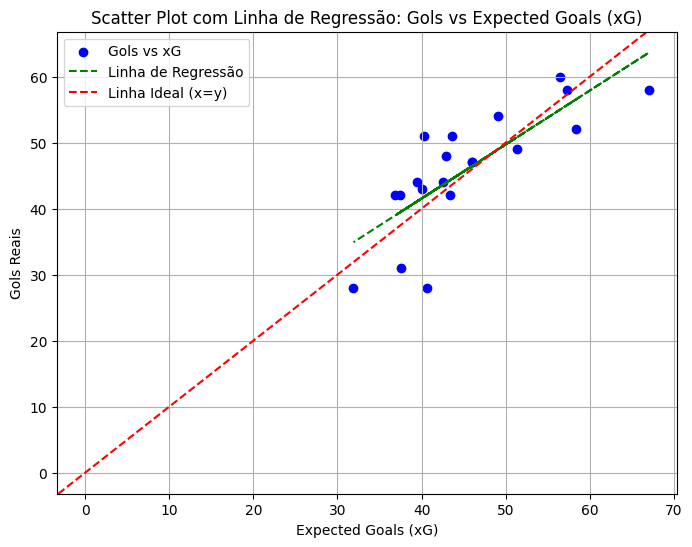

In [33]:
# Ajustar uma linha de regressão linear
m, b = np.polyfit(merged_df['Expected_xG'], merged_df['Performance_Gls'], 1)

# Plotar scatter e linha de regressão
plt.figure(figsize=(8, 6))
plt.scatter(merged_df['Expected_xG'], merged_df['Performance_Gls'], color='blue', label='Gols vs xG')
plt.plot(merged_df['Expected_xG'], m * merged_df['Expected_xG'] + b, color='green', linestyle='--', label='Linha de Regressão')

# Adicionar linha ideal
plt.axline((0, 0), slope=1, color='red', linestyle='--', label='Linha Ideal (x=y)')

plt.xlabel('Expected Goals (xG)')
plt.ylabel('Gols Reais')
plt.title('Scatter Plot com Linha de Regressão: Gols vs Expected Goals (xG)')
plt.legend()
plt.grid(True)
plt.show()


In [34]:
#Calcular o retorno sobre investimento (ROI) com base no desempenho.
merged_df['ROI'] = (merged_df['Performance_Gls'] + merged_df['Performance_Ast']) / df['Valor de Mercado (€)']
merged_df[['team','ROI']]

,team,ROI
0,Botafogo,0.753253
1,Palmeiras,0.607446
2,Flamengo,0.476302
3,Fortaleza,1.975583
4,Internacional,0.689767
5,São Paulo,0.764835
6,Corinthians,0.618557
7,Bahia,1.156595
8,Cruzeiro,0.717939
9,Vasco da Gama,0.691912


In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score

# Copiar o dataframe para nao altera-lo
df_copy = merged_df.copy()

# Criar a coluna 'Posicao' com base em 'Pts', utilizando 'W' como critério de desempate
df_copy['Posicao'] = df_copy.sort_values(['Pts', 'W'], ascending=[False, False]).index + 1

# Redefinir o índice para corresponder à nova ordem de 'Posicao'
df_copy = df_copy.reset_index(drop=True)

# Variáveis de entrada (X) e alvo (y)
X = df_copy[['GF', 'GA', 'GD', 'Expected_xG', 'Expected_xAG', 'Poss_','Performance_CrdY','Performance_CrdR',]]
y = df_copy['Posicao']

# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Treinar a regressão linear
model = LinearRegression()
model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_test)
y_pred = np.clip(y_pred, 1, 20)  # Limitar valores entre 1 e 20

#Avaliar o modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error (MSE): 7.96
R² Score: 0.84


In [42]:
# Treinar o modelo de regressão linear com todos os dados
model = LinearRegression()
model.fit(X, y)  # X: Variáveis de entrada, y: Posições reais

# Prever as posições para todos os times
df_copy['Posicao Prevista'] = model.predict(X).round()  # Arredondar as previsões para valores inteiros
df_copy['Posicao Prevista'] = np.clip(df_copy['Posicao Prevista'], 1, 20)  # Garantir valores válidos (1 a 20)

# Ordenar por 'Posicao Prevista' e critério adicional de desempate (exemplo: 'W')
df_copy = df_copy.sort_values(by=['Posicao Prevista', 'W'], ascending=[True, False])

# Criar uma coluna 'Posicao Ajustada' com valores únicos
df_copy['Posicao Ajustada'] = range(1, len(df_copy) + 1)

# Criar DataFrame para comparar posições reais, previstas e ajustadas
resultados = pd.DataFrame({
    "Time": df_copy['team'],                   # Nome dos times
    "Posicao Real": df_copy['Posicao'],        # Posições reais
    "Posicao Prevista": df_copy['Posicao Prevista'],  # Posições previstas pelo modelo
    "Posicao Ajustada": df_copy['Posicao Ajustada'],  # Posições ajustadas
})

# Calcular o erro com base na posição ajustada
resultados['Erro'] = resultados['Posicao Real'] - resultados['Posicao Ajustada']

# Exibir o DataFrame de resultados
print(resultados)


                   Time  Posicao Real  Posicao Prevista  Posicao Ajustada  \
0              Botafogo             1               1.0                 1   
1             Palmeiras             2               2.0                 2   
2              Flamengo             3               2.0                 3   
3             Fortaleza             4               5.0                 4   
4         Internacional             5               6.0                 5   
5             São Paulo             6               6.0                 6   
6           Corinthians             7               8.0                 7   
7                 Bahia             8               9.0                 8   
8              Cruzeiro             9              10.0                 9   
13               Grêmio            14              12.0                10   
15  Red Bull Bragantino            16              12.0                11   
9         Vasco da Gama            10              13.0                12   

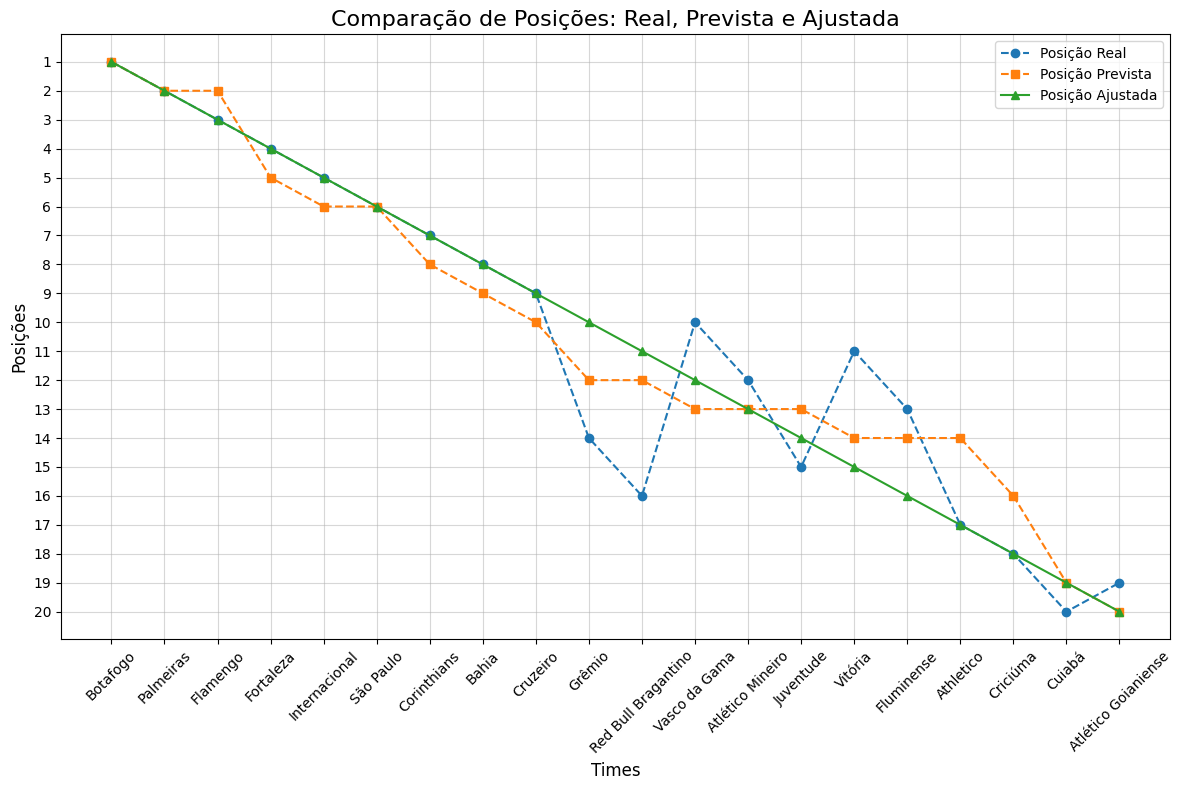

In [43]:
# Criar o gráfico de comparação
plt.figure(figsize=(12, 8))

# Plotar as posições reais
plt.plot(resultados['Time'], resultados['Posicao Real'], marker='o', label='Posição Real', linestyle='--')

# Plotar as posições previstas
plt.plot(resultados['Time'], resultados['Posicao Prevista'], marker='s', label='Posição Prevista', linestyle='--')

# Plotar as posições ajustadas
plt.plot(resultados['Time'], resultados['Posicao Ajustada'], marker='^', label='Posição Ajustada', linestyle='-')

# Adicionar títulos e rótulos
plt.title('Comparação de Posições: Real, Prevista e Ajustada', fontsize=16)
plt.xlabel('Times', fontsize=12)
plt.ylabel('Posições', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(range(1, len(resultados) + 1))  # Ajusta o eixo Y para o intervalo de posições
plt.gca().invert_yaxis()  # Inverter o eixo Y para refletir a ordem do ranking

# Adicionar legenda
plt.legend()

# Adicionar grades para melhor visualização
plt.grid(alpha=0.5)

# Exibir o gráfico
plt.tight_layout()
plt.show()
